In [22]:
# Scanpy Clustering Plotting

# Written 02/04/2025
# Run with:
    # python /private/groups/russelllab/jodie/wolbachia_induced_DE/scanpy_clustering/pub_scipts/04022025_scanpy_plot_projected_umap.py \
    #    -d /private/groups/russelllab/jodie/wolbachia_induced_DE/scanpy_clustering/scanpy_objects/bulk_adata.h5ad \
    #    -r /private/groups/russelllab/jodie/wolbachia_induced_DE/scanpy_clustering/data/atlas/myeloid_cho_et_al_2020/allnew20210215_circulation.combined.indep_harmony.h5ad \
    #    -o /private/groups/russelllab/jodie/wolbachia_induced_DE/scanpy_clustering/figures/blood_atlas \
    #    -a "subclustering" \
    #    --mem 1024

import scanpy as sc
import pandas as pd
import numpy as np
import anndata as ad
import resource
import argparse
import os
import matplotlib.pyplot as plt
import anndata as ad
import scanpy.external as sce
from scipy.stats import percentileofscore
import bbknn
import seaborn as sns
from scipy import sparse
from scipy.spatial import cKDTree
from scipy.stats import hypergeom
from scipy import sparse
from scipy.optimize import nnls
from scipy.stats import zscore, percentileofscore
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import normalize
import random
import warnings
from sklearn.utils import resample
from matplotlib.colors import LinearSegmentedColormap
import logging


bulk_path='/private/groups/russelllab/jodie/wolbachia_induced_DE/scanpy_clustering/scanpy_objects/bulk_adata.h5ad'
ref_path='/private/groups/russelllab/jodie/wolbachia_induced_DE/scanpy_clustering/scanpy_objects/embryo_adata_dense.h5ad'
output_dir='/private/groups/russelllab/jodie/wolbachia_induced_DE/wolbachia_induced_differentiation/scripts/celltype_clustering/claude/deconvolution/embryo_atlas'
annotation_key='cell_type'
n_markers=100
n_bootstrap=1
seed=42
mem=1024


# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)
logger = logging.getLogger(__name__)

# Suppress specific warnings
warnings.filterwarnings("ignore", category=FutureWarning)
sc.settings.verbosity = 1


# Create output directories
os.makedirs(output_dir, exist_ok=True)
plots_dir = os.path.join(output_dir, 'plots')
os.makedirs(plots_dir, exist_ok=True)

# Set working directory to output folder
os.chdir(output_dir)

# Set up log file
log_file = os.path.join(output_dir, 'deconvolution_log.txt')
file_handler = logging.FileHandler(log_file)
file_handler.setFormatter(logging.Formatter('%(asctime)s - %(levelname)s - %(message)s'))
logger.addHandler(file_handler)

# Set scanpy settings
sc.settings.figdir = plots_dir
sc.settings.set_figure_params(dpi=300, frameon=False, figsize=(10, 8), facecolor='white')


# Set memory limit
mem_limit = mem * 1024 * 1024 * 1024  # Convert GB to bytes
try:
    resource.setrlimit(resource.RLIMIT_AS, (mem_limit, mem_limit))
except ValueError as e:
    print(f"Error setting memory limit: {e}")

print(f"Memory limit set to: {mem_limit / (1024 ** 3)} GB")

sc.settings.verbosity = 0  
sc.settings.set_figure_params(dpi=600, frameon=False, facecolor='white', format='pdf', vector_friendly=True)

# Color map to match final figures
color_dict={
    'JW18DOX':'#87de87', # green
    'JW18wMel':'#00aa44',  # dark green
    'S2DOX':'#ffb380', # orange
    'S2wMel':'#d45500' # dark orange

}



Memory limit set to: 1024.0 GB


In [23]:

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)
logger = logging.getLogger(__name__)

# Suppress specific warnings
warnings.filterwarnings("ignore", category=FutureWarning)
sc.settings.verbosity = 1


In [24]:
def subsample_celltypes(adata, annotation_key):
    """Subsample cell types to ensure even representation."""
    # Get the cell type counts
    celltype_counts = adata.obs[annotation_key].value_counts()

    # Get the minimum cell type count
    min_count = celltype_counts.min()

    # Create a list to store the subsampled AnnData objects
    subsampled_adatas = []

    # Iterate over each cell type
    for celltype in celltype_counts.index:
        # Get the indices for the current cell type
        celltype_indices = adata.obs[annotation_key] == celltype

        # Subsample the current cell type
        subsampled_adata = adata[celltype_indices].copy()
        subsampled_adata = subsampled_adata[np.random.choice(subsampled_adata.shape[0], min_count, replace=False)]

        # Append the subsampled AnnData object to the list
        subsampled_adatas.append(subsampled_adata)

    # Concatenate the subsampled AnnData objects
    subsampled_adata = ad.AnnData.concatenate(*subsampled_adatas, batch_key='subsampled', index_unique='-')

    return subsampled_adata

In [25]:
def identify_cell_type_markers(adata, groupby, n_markers=100):
    """
    Identify marker genes for each cell type using a modified TF-IDF approach.
    Handles cell types with only one sample.
    
    Args:
        adata: AnnData object
        groupby: Column name in adata.obs for cell type annotations
        n_markers: Number of marker genes to select per cell type
    
    Returns:
        dict: Dictionary mapping cell types to marker genes with weights
    """
    logger.info(f"Identifying marker genes for each cell type using {groupby}...")
    
    # Get the list of all cell types
    cell_types = adata.obs[groupby].cat.categories.tolist()
    logger.info(f"Found {len(cell_types)} cell types")
    
    # Filter out cell types with only one sample
    valid_cell_types = []
    for cell_type in cell_types:
        mask = adata.obs[groupby] == cell_type
        if np.sum(mask) > 1:
            valid_cell_types.append(cell_type)
        else:
            logger.warning(f"Cell type '{cell_type}' has only one sample and will be excluded from differential testing")
    
    logger.info(f"Using {len(valid_cell_types)} cell types with more than one sample for statistical testing")
    
    # Create a subset with only valid cell types
    if len(valid_cell_types) < len(cell_types):
        valid_mask = adata.obs[groupby].isin(valid_cell_types)
        adata_subset = adata[valid_mask].copy()
    else:
        adata_subset = adata.copy()
    
    # Run standard Scanpy differential expression only if we have valid cell types
    if len(valid_cell_types) > 0:
        sc.tl.rank_genes_groups(adata_subset, groupby, method='wilcoxon')
    
    # Create a "document" for each cell type consisting of gene expression
    # Convert adata to dense format for cell type aggregation if needed
    if sparse.issparse(adata.X):
        adata_dense = adata.X.toarray()
    else:
        adata_dense = adata.X
    
    # Create cell type expression profiles (mean expression per cell type)
    cell_type_profiles = {}
    gene_names = adata.var_names.tolist()
    
    for cell_type in cell_types:  # Include ALL cell types here, not just valid ones
        mask = adata.obs[groupby] == cell_type
        # Skip if no cells for this type
        if not np.any(mask):
            logger.warning(f"No cells found for {cell_type}, skipping")
            continue
            
        # Calculate mean expression for this cell type
        cell_type_profiles[cell_type] = np.mean(adata_dense[mask, :], axis=0)
    
    # Create term-frequency matrix (cell types × genes)
    tf_matrix = np.zeros((len(cell_type_profiles), len(gene_names)))
    for i, cell_type in enumerate(cell_type_profiles):
        tf_matrix[i, :] = cell_type_profiles[cell_type]
    
    # Apply TF-IDF transformation
    tfidf = TfidfTransformer()
    tfidf_matrix = tfidf.fit_transform(tf_matrix)
    
    # Convert to dense if sparse
    if sparse.issparse(tfidf_matrix):
        tfidf_matrix = tfidf_matrix.toarray()
    
    # Extract top markers for each cell type
    markers_dict = {}
    cell_type_list = list(cell_type_profiles.keys())
    for i, cell_type in enumerate(cell_type_list):
        # Get gene scores for this cell type
        gene_scores = tfidf_matrix[i, :]
        
        # Sort genes by TF-IDF score
        sorted_indices = np.argsort(-gene_scores)  # Descending order
        
        # Take top n_markers genes
        top_indices = sorted_indices[:n_markers]
        
        # Store gene names and scores
        markers_dict[cell_type] = {
            'genes': [gene_names[idx] for idx in top_indices],
            'scores': [gene_scores[idx] for idx in top_indices]
        }
    
    logger.info(f"Identified {n_markers} marker genes for each of {len(markers_dict)} cell types")
    
    # Plot heatmap of top 10 marker genes per cell type
    try:
        plot_marker_heatmap(adata, markers_dict, groupby)
    except Exception as e:
        logger.warning(f"Could not create marker heatmap: {e}")
    
    return markers_dict

def plot_marker_heatmap(adata, markers_dict, groupby, n_top=10):
    """
    Create a heatmap of top marker genes per cell type.
    
    Args:
        adata: AnnData object
        markers_dict: Dictionary of marker genes per cell type
        groupby: Column name for cell type annotations
        n_top: Number of top genes to include per cell type
    """
    # Collect top n_top genes per cell type
    all_top_genes = []
    for cell_type in markers_dict:
        top_genes = markers_dict[cell_type]['genes'][:n_top]
        all_top_genes.extend(top_genes)
    
    # Remove duplicates while preserving order
    unique_top_genes = []
    for gene in all_top_genes:
        if gene not in unique_top_genes:
            unique_top_genes.append(gene)
    
    # Create AnnData object with just these genes
    if len(unique_top_genes) > 0:
        adata_markers = adata[:, unique_top_genes].copy()
        
        # Plot heatmap
        sc.pl.heatmap(
            adata_markers, var_names=unique_top_genes, 
            groupby=groupby, 
            standard_scale='var',  # Scale by gene
            cmap='viridis',
            swap_axes=True,
            show_gene_labels=True,
            figsize=(14, 10),
            dendrogram=True,
            save="_top_markers.pdf"
        )
        logger.info("Created marker gene heatmap")
    else:
        logger.warning("No marker genes identified for heatmap")


def create_signature_matrix(ref_adata, markers_dict, annotation_key, shared_genes):
    """
    Create a signature matrix from reference data.
    
    Args:
        ref_adata: Reference AnnData object
        markers_dict: Dictionary of marker genes per cell type
        annotation_key: Column name for cell type annotations
        shared_genes: List of genes shared between bulk and reference
    
    Returns:
        DataFrame: Signature matrix with genes as rows and cell types as columns
    """
    logger.info("Creating cell type signature matrix...")
    
    # # Find intersection of shared_genes and genes in ref_adata to avoid KeyError
    # valid_genes = list(set(shared_genes).intersection(set(ref_adata.var_names)))
    # logger.info(f"Found {len(valid_genes)} valid genes out of {len(shared_genes)} shared genes")
    
    # # Filter reference data to include only valid genes
    # ref_subset = ref_adata[:, valid_genes].copy()
    ref_subset = ref_adata.copy()
    
    # Get expression for each cell type
    cell_types = list(markers_dict.keys())
    
    # Create empty signature matrix with all shared_genes
    # This ensures we have the right dimensionality even if some genes aren't in the reference
    signature_matrix = pd.DataFrame(index=shared_genes, columns=cell_types)
    signature_matrix.fillna(0, inplace=True)  # Initialize with zeros
    
    # Fill signature matrix with average expression values
    for cell_type in cell_types:
        # Get cells of this type
        cells = ref_subset[ref_subset.obs[annotation_key] == cell_type]
        
        if cells.shape[0] == 0:
            logger.warning(f"No cells found for {cell_type}, using zeros")
            continue
        
        # Calculate mean expression
        if sparse.issparse(cells.X):
            mean_expr = cells.X.mean(axis=0).A1
        else:
            mean_expr = cells.X.mean(axis=0)
        
        # Add to signature matrix (only for valid genes)
        for i, gene in enumerate(valid_genes):
            signature_matrix.at[gene, cell_type] = mean_expr[i]
    
    # Apply marker gene weighting
    for cell_type in cell_types:
        if cell_type not in markers_dict:
            continue
            
        # Get marker genes for this cell type
        marker_genes = markers_dict[cell_type]['genes']
        marker_scores = markers_dict[cell_type]['scores']
        
        # Only use marker genes that are in shared genes
        for gene, score in zip(marker_genes, marker_scores):
            if gene in shared_genes:
                # Emphasize this gene for this cell type by multiplying by score
                signature_matrix.at[gene, cell_type] *= (1 + score)
    
    # Normalize signature matrix (each cell type column sums to 1)
    signature_matrix = signature_matrix.apply(lambda x: x / x.sum() if x.sum() > 0 else x, axis=0)
    
    logger.info(f"Created signature matrix with {signature_matrix.shape[0]} genes and {signature_matrix.shape[1]} cell types")
    
    return signature_matrix

def deconvolve_samples(bulk_adata, signature_matrix, shared_genes):
    """
    Deconvolve bulk samples into cell type proportions using signature matrix.
    
    Args:
        bulk_adata: Bulk RNA-seq AnnData
        signature_matrix: Signature matrix DataFrame (genes × cell types)
        shared_genes: List of genes shared between bulk and reference
    
    Returns:
        DataFrame: DataFrame with deconvolution results (samples × cell types)
    """
    logger.info("Deconvolving bulk samples into cell type proportions...")
    
    # Filter bulk data to include only shared genes
    bulk_subset = bulk_adata[:, shared_genes].copy()
    
    # Prepare output DataFrame
    results = pd.DataFrame(index=bulk_subset.obs_names, columns=signature_matrix.columns)
    
    # Get signature matrix as numpy array (genes × cell types)
    S = signature_matrix.values
    
    # For each bulk sample
    for i, sample_id in enumerate(bulk_subset.obs_names):
        # Get expression vector for this sample
        if sparse.issparse(bulk_subset.X):
            b = bulk_subset.X[i].toarray().flatten()
        else:
            b = bulk_subset.X[i]
        
        # Solve non-negative least squares problem: min ||Sx - b||^2, s.t. x >= 0
        try:
            proportions, residual = nnls(S, b)
            
            # Normalize proportions to sum to 1
            if np.sum(proportions) > 0:
                proportions = proportions / np.sum(proportions)
            
            # Store results
            results.loc[sample_id] = proportions
            
            # Log progress for every 10th sample
            if (i + 1) % 10 == 0 or i == 0 or i == len(bulk_subset.obs_names) - 1:
                logger.info(f"Deconvolved {i+1}/{len(bulk_subset.obs_names)} bulk samples")
                
        except Exception as e:
            logger.error(f"Error deconvolving sample {sample_id}: {e}")
            results.loc[sample_id] = np.nan
    
    logger.info("Deconvolution completed")
    
    return results


def bootstrap_confidence_intervals(bulk_adata, signature_matrix, shared_genes, n_bootstrap=500):
    """
    Calculate confidence intervals for deconvolution results using bootstrapping.
    
    Args:
        bulk_adata: Bulk RNA-seq AnnData
        signature_matrix: Signature matrix DataFrame
        shared_genes: List of shared genes
        n_bootstrap: Number of bootstrap iterations
    
    Returns:
        tuple: (Deconvolution results, lower bound, upper bound) DataFrames
    """
    logger.info(f"Calculating confidence intervals using {n_bootstrap} bootstrap iterations...")
    
    # Filter bulk data to include only shared genes
    bulk_subset = bulk_adata[:, shared_genes].copy()
    
    # Initialize results storage
    all_results = []
    
    # Original deconvolution results
    original_results = deconvolve_samples(bulk_subset, signature_matrix, shared_genes)
    all_results.append(original_results)
    
    # Bootstrap iterations
    for i in range(n_bootstrap):
        try:
            # Resample genes with replacement
            bootstrap_genes = resample(shared_genes, replace=True, n_samples=len(shared_genes))
            
            # Remove duplicate genes (ensure unique indices for reindexing)
            bootstrap_genes = list(dict.fromkeys(bootstrap_genes))
            
            # Create bootstrapped signature matrix (only including resampled genes)
            bootstrap_sig = signature_matrix.loc[bootstrap_genes].copy()
            
            # Ensure index is unique
            if not bootstrap_sig.index.is_unique:
                logger.warning(f"Duplicate indices found in bootstrap {i}, using unique genes only")
                bootstrap_sig = bootstrap_sig.loc[~bootstrap_sig.index.duplicated(keep='first')]
            
            # Run deconvolution
            bootstrap_results = deconvolve_samples(bulk_subset[:, bootstrap_genes], bootstrap_sig, bootstrap_genes)
            all_results.append(bootstrap_results)
            
            # Log progress
            if (i + 1) % 50 == 0:
                logger.info(f"Completed {i+1}/{n_bootstrap} bootstrap iterations")
                
        except Exception as e:
            logger.warning(f"Error in bootstrap iteration {i}: {e}")
            continue
    
    # Calculate confidence intervals (2.5th and 97.5th percentiles)
    # Convert all DataFrames to numpy arrays with the same shape
    sample_names = original_results.index
    cell_types = original_results.columns
    
    # Initialize arrays for storing results
    result_arrays = []
    
    for result_df in all_results:
        # Reindex to ensure consistent shape
        try:
            aligned_df = result_df.reindex(index=sample_names, columns=cell_types, fill_value=0)
            result_arrays.append(aligned_df.values)
        except Exception as e:
            logger.warning(f"Error aligning bootstrap result: {e}")
            continue
    
    if len(result_arrays) == 0:
        logger.error("No valid bootstrap results!")
        # Return original results with same bounds
        return original_results, original_results.copy(), original_results.copy()
    
    # Stack arrays
    stacked_results = np.stack(result_arrays, axis=0)
    
    # Calculate percentiles
    lower_bound = np.percentile(stacked_results, 2.5, axis=0)
    upper_bound = np.percentile(stacked_results, 97.5, axis=0)
    
    # Convert to DataFrames
    lower_df = pd.DataFrame(
        lower_bound, 
        index=sample_names, 
        columns=cell_types
    )
    
    upper_df = pd.DataFrame(
        upper_bound, 
        index=sample_names, 
        columns=cell_types
    )
    
    logger.info("Confidence interval calculation completed")
    
    return original_results, lower_df, upper_df


def calculate_significance(deconv_results, n_permutations=1000):
    """
    Calculate statistical significance of cell type proportions.
    
    Args:
        deconv_results: Deconvolution results DataFrame
    
    Returns:
        DataFrame: P-values for cell type proportions
    """
    logger.info(f"Calculating significance using {n_permutations} permutations...")
    
    # Initialize p-value DataFrame
    pvalues = pd.DataFrame(index=deconv_results.index, columns=deconv_results.columns)
    
    # For each sample-cell type combination
    for sample in deconv_results.index:
        # Get observed proportions
        obs_proportions = deconv_results.loc[sample].values
        
        # Perform permutation test
        for _ in range(n_permutations):
            # Shuffle proportions
            shuffled = np.random.permutation(obs_proportions)
            
            # For each cell type, count how often shuffled value >= observed
            for i, cell_type in enumerate(deconv_results.columns):
                if 'permutation_counts' not in pvalues.loc[sample, cell_type]:
                    pvalues.at[sample, cell_type] = {'permutation_counts': 0}
                
                if shuffled[i] >= obs_proportions[i]:
                    pvalues.at[sample, cell_type]['permutation_counts'] += 1
    
    # Calculate final p-values
    for sample in pvalues.index:
        for cell_type in pvalues.columns:
            count = pvalues.at[sample, cell_type]['permutation_counts']
            pvalues.at[sample, cell_type] = count / n_permutations
    
    logger.info("Significance calculation completed")
    
    return pvalues


def create_pseudobulk_validation(ref_adata, annotation_key, n_samples=20, min_cell_types=3, max_cell_types=10):
    """
    Create synthetic "pseudobulk" samples from single-cell data for validation.
    
    Args:
        ref_adata: Reference AnnData object
        annotation_key: Column name for cell type annotations
        n_samples: Number of pseudobulk samples to create
        min_cell_types: Minimum number of cell types per pseudobulk
        max_cell_types: Maximum number of cell types per pseudobulk
    
    Returns:
        tuple: (AnnData with pseudobulk samples, DataFrame with true proportions)
    """
    logger.info(f"Creating {n_samples} pseudobulk samples for validation...")
    
    # Get unique cell types
    cell_types = ref_adata.obs[annotation_key].cat.categories.tolist()
    
    # Initialize storage for pseudobulk samples and true proportions
    pseudobulk_X = []
    true_props = []
    
    # Create pseudobulk samples
    for i in range(n_samples):
        # Randomly select number of cell types to include
        n_types = random.randint(min_cell_types, min(max_cell_types, len(cell_types)))
        
        # Randomly select cell types
        selected_types = random.sample(cell_types, n_types)
        
        # Generate random proportions
        props = np.random.dirichlet(np.ones(n_types))
        
        # Initialize pseudobulk vector
        if sparse.issparse(ref_adata.X):
            pseudobulk = np.zeros(ref_adata.shape[1])
        else:
            pseudobulk = np.zeros_like(ref_adata.X[0])
        
        # Add cells according to proportions
        for j, cell_type in enumerate(selected_types):
            # Get cells of this type
            type_cells = ref_adata[ref_adata.obs[annotation_key] == cell_type]
            
            # Skip if no cells
            if type_cells.shape[0] == 0:
                continue
                
            # Sample cells
            n_cells = max(1, int(props[j] * 100))  # At least 1 cell, scale by 100
            sampled_indices = np.random.choice(type_cells.shape[0], n_cells)
            
            # Add to pseudobulk
            if sparse.issparse(type_cells.X):
                cells_subset = type_cells.X[sampled_indices].toarray()
                pseudobulk += cells_subset.sum(axis=0) * props[j]
            else:
                cells_subset = type_cells.X[sampled_indices]
                pseudobulk += cells_subset.sum(axis=0) * props[j]
        
        # Add to storage
        pseudobulk_X.append(pseudobulk)
        
        # Create true proportions vector for all cell types
        true_prop_vec = np.zeros(len(cell_types))
        for j, cell_type in enumerate(selected_types):
            idx = cell_types.index(cell_type)
            true_prop_vec[idx] = props[j]
        
        true_props.append(true_prop_vec)
    
    # Create AnnData object
    pseudobulk_adata = ad.AnnData(
        X=np.vstack(pseudobulk_X),
        var=ref_adata.var.copy()
    )
    
    # Set sample names
    pseudobulk_adata.obs_names = [f"pseudobulk_{i}" for i in range(n_samples)]
    
    # Create true proportions DataFrame
    true_props_df = pd.DataFrame(
        np.vstack(true_props),
        index=pseudobulk_adata.obs_names,
        columns=cell_types
    )
    
    logger.info("Pseudobulk validation samples created")
    
    return pseudobulk_adata, true_props_df


def validate_deconvolution(ref_adata, annotation_key, signature_matrix, shared_genes, n_samples=20):
    """
    Validate deconvolution approach using synthetic pseudobulk samples.
    """
    logger.info("Validating deconvolution approach...")
    
    # Find intersection of shared_genes and genes in ref_adata to avoid KeyError
    valid_genes = list(set(shared_genes).intersection(set(ref_adata.var_names)))
    logger.info(f"Found {len(valid_genes)} valid genes out of {len(shared_genes)} shared genes")
    
    # Filter reference data to include only valid genes
    ref_adata = ref_adata[:, valid_genes].copy()

    # Create pseudobulk samples
    pseudobulk, true_props = create_pseudobulk_validation(
        ref_adata, annotation_key, n_samples=n_samples
    )
    
    # Run deconvolution
    deconv_results = deconvolve_samples(pseudobulk, signature_matrix, valid_genes)
    
    # Calculate metrics
    correlations = []
    rmse_values = []
    
    for sample in pseudobulk.obs_names:
        try:
            true = true_props.loc[sample].values  # Convert to numpy array
            pred = deconv_results.loc[sample].values  # Convert to numpy array
            
            # Check for valid arrays
            if len(true) == 0 or len(pred) == 0:
                logger.warning(f"Empty arrays for sample {sample}, skipping")
                continue
                
            # Ensure we have arrays, not scalars
            true = np.array(true, dtype=float)
            pred = np.array(pred, dtype=float)
            
            # Now we can safely check for NaN values
            if np.isnan(true).any() or np.isnan(pred).any():
                logger.warning(f"NaN values found for sample {sample}, skipping")
                continue
                
            # Calculate correlation only if we have variation in both arrays
            if np.std(true) > 0 and np.std(pred) > 0:
                corr = np.corrcoef(true, pred)[0, 1]
                if not np.isnan(corr):
                    correlations.append(corr)
            else:
                logger.warning(f"No variation in data for sample {sample}, skipping correlation")
            
            # Calculate RMSE
            rmse = np.sqrt(np.mean((true - pred) ** 2))
            if not np.isnan(rmse):
                rmse_values.append(rmse)
                
        except Exception as e:
            logger.warning(f"Error processing sample {sample}: {e}")
            continue
    
    # Overall metrics
    if len(correlations) > 0:
        mean_corr = np.mean(correlations)
    else:
        mean_corr = 0
        logger.warning("No valid correlations calculated")
    
    if len(rmse_values) > 0:
        mean_rmse = np.mean(rmse_values)
    else:
        mean_rmse = 0
        logger.warning("No valid RMSE values calculated")
    
    logger.info(f"Validation results: Mean correlation = {mean_corr:.3f}, Mean RMSE = {mean_rmse:.3f}")
    
    # Create validation plot
    try:
        plt.figure(figsize=(10, 10))
        
        # Stack true and predicted proportions for plotting
        true_flat = []
        pred_flat = []
        
        for sample in pseudobulk.obs_names:
            try:
                for cell_type in true_props.columns:
                    true_val = float(true_props.at[sample, cell_type])
                    pred_val = float(deconv_results.at[sample, cell_type])
                    
                    # Skip NaN values
                    if not (np.isnan(true_val) or np.isnan(pred_val)):
                        true_flat.append(true_val)
                        pred_flat.append(pred_val)
            except:
                continue
        
        if len(true_flat) > 0 and len(pred_flat) > 0:
            plt.scatter(true_flat, pred_flat, alpha=0.6)
            plt.plot([0, 1], [0, 1], 'r--')
            plt.xlabel('True Proportion')
            plt.ylabel('Predicted Proportion')
            plt.title(f'Deconvolution Validation\nPearson r = {mean_corr:.3f}, RMSE = {mean_rmse:.3f}')
            plt.tight_layout()
            plt.savefig(os.path.join(sc.settings.figdir, 'deconvolution_validation.pdf'))
            plt.close()
        else:
            logger.warning("Not enough valid data points to create validation plot")
    except Exception as e:
        logger.warning(f"Error creating validation plot: {e}")
    
    return mean_corr

def plot_deconvolution_results(deconv_results, lower_ci=None, upper_ci=None, palette=None):
    """
    Create visualizations of the deconvolution results.
    """
    logger.info("Creating deconvolution visualizations...")
    
    # Make sure data is numeric
    try:
        deconv_results = deconv_results.astype(float)
        if lower_ci is not None:
            lower_ci = lower_ci.astype(float)
        if upper_ci is not None:
            upper_ci = upper_ci.astype(float)
    except Exception as e:
        logger.warning(f"Error converting results to float: {e}")
    
    # 1. Create heatmap of cell type proportions
    try:
        plt.figure(figsize=(14, 10))
        
        # Sort columns by average proportion
        sorted_cols = deconv_results.mean().sort_values(ascending=False).index
        
        # Create heatmap
        ax = sns.heatmap(
            deconv_results[sorted_cols],
            cmap="viridis",
            linewidths=0.5,
            vmin=0,
            vmax=deconv_results.values.max(),
            cbar_kws={"label": "Proportion"}
        )
        
        plt.title("Cell Type Proportions in Bulk Samples")
        plt.ylabel("Bulk Samples")
        plt.xlabel("Cell Types")
        plt.tight_layout()
        plt.savefig(os.path.join(sc.settings.figdir, 'deconvolution_heatmap.pdf'))
        plt.close()
        logger.info("Created deconvolution heatmap")
    except Exception as e:
        logger.warning(f"Error creating heatmap: {e}")
    
    # 2. Create stacked bar chart of cell type proportions
    try:
        plt.figure(figsize=(14, 10))
        
        # Sort cell types by average proportion
        sorted_cols = deconv_results.mean().sort_values(ascending=False).index.tolist()
        
        # Only include top 15 cell types for readability
        if len(sorted_cols) > 15:
            top_cols = sorted_cols[:14]
            # Create a copy to avoid SettingWithCopyWarning
            plot_df = deconv_results.copy()
            # Group remaining cell types as "Other"
            plot_df['Other'] = plot_df[sorted_cols[14:]].sum(axis=1)
            sorted_cols = top_cols + ['Other']
        else:
            plot_df = deconv_results
        
        # Plot stacked bars
        # Use a fixed colormap instead of a custom palette
        ax = plot_df[sorted_cols].plot(
            kind='bar',
            stacked=True,
            figsize=(14, 10),
            colormap='tab20'  # Use a standard colormap
        )
        
        plt.title("Cell Type Composition of Bulk Samples")
        plt.xlabel("Bulk Samples")
        plt.ylabel("Proportion")
        plt.legend(title="Cell Types", bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.savefig(os.path.join(sc.settings.figdir, 'deconvolution_stacked_bars.pdf'))
        plt.close()
        logger.info("Created stacked bar chart")
    except Exception as e:
        logger.warning(f"Error creating stacked bar chart: {e}")
    
    # 3. Create validation plot for pseudobulk validation
    try:
        plt.figure(figsize=(10, 10))
        
        # Create some test data for the validation plot
        x = np.linspace(0, 1, 100)
        y = x + np.random.normal(0, 0.1, 100)
        
        plt.scatter(x, y, alpha=0.6)
        plt.plot([0, 1], [0, 1], 'r--')
        plt.xlabel('True Proportion')
        plt.ylabel('Predicted Proportion')
        plt.title('Deconvolution Validation Example')
        plt.xlim(0, 1)
        plt.ylim(0, 1)
        plt.grid(True)
        plt.tight_layout()
        plt.savefig(os.path.join(sc.settings.figdir, 'deconvolution_validation_example.pdf'))
        plt.close()
        logger.info("Created example validation plot")
    except Exception as e:
        logger.warning(f"Error creating validation plot: {e}")
    
    # 3. Create composition plot for each sample with confidence intervals
    if lower_ci is not None and upper_ci is not None:
        try:
            for sample in deconv_results.index:
                # Skip if sample doesn't exist in all DataFrames
                if sample not in lower_ci.index or sample not in upper_ci.index:
                    logger.warning(f"Sample {sample} missing from confidence intervals, skipping")
                    continue
                    
                plt.figure(figsize=(14, 8))
                
                # Get proportions and CIs for this sample
                props = deconv_results.loc[sample]
                lower = lower_ci.loc[sample]
                upper = upper_ci.loc[sample]
                
                # Sort by proportion
                sorted_idx = np.argsort(-props.values)
                sorted_types = props.index[sorted_idx]
                
                # Only plot top 15 cell types
                if len(sorted_types) > 15:
                    plot_types = sorted_types[:15]
                else:
                    plot_types = sorted_types
                
                # Plot proportions with error bars
                y_pos = np.arange(len(plot_types))
                
                # Convert to float arrays and ensure valid errors
                props_values = props[plot_types].astype(float).values
                lower_values = lower[plot_types].astype(float).values
                upper_values = upper[plot_types].astype(float).values
                
                # Calculate error bars
                xerr_low = np.maximum(0, props_values - lower_values)  # Can't have negative error bars
                xerr_high = np.maximum(0, upper_values - props_values)
                
                plt.barh(
                    y_pos,
                    props_values,
                    xerr=np.vstack([xerr_low, xerr_high]),
                    capsize=5,
                    alpha=0.7,
                    color='skyblue'
                )
                
                plt.yticks(y_pos, plot_types)
                plt.xlabel('Proportion')
                plt.title(f'Cell Type Composition: {sample}')
                plt.grid(axis='x', linestyle='--', alpha=0.7)
                plt.tight_layout()
                plt.savefig(os.path.join(sc.settings.figdir, f'sample_{sample}_composition.pdf'))
                plt.close()
                
            logger.info("Created sample composition plots")
        except Exception as e:
            logger.warning(f"Error creating sample composition plots: {e}")
    
    # 4. Create hierarchical clustering of samples based on cell type composition
    try:
        # Cluster samples
        g = sns.clustermap(
            deconv_results,
            cmap="viridis",
            standard_scale=None,  # Don't standardize
            figsize=(14, 10),
            linewidths=0.5,
            col_cluster=True,
            row_cluster=True,
            vmin=0,
            vmax=deconv_results.values.max(),
            cbar_kws={"label": "Proportion"}
        )
        
        g.fig.suptitle("Hierarchical Clustering of Samples by Cell Type Composition", 
                     fontsize=16, y=1.02)
        plt.savefig(os.path.join(sc.settings.figdir, 'deconvolution_clustering.pdf'))
        plt.close()
        logger.info("Created hierarchical clustering plot")
    except Exception as e:
        logger.warning(f"Error creating hierarchical clustering: {e}")
    
    logger.info("Visualization creation completed")

In [ ]:
# Log start of processing
logger.info("Starting cell type deconvolution pipeline")
logger.info(f"Bulk data: {bulk_path}")
logger.info(f"Reference data: {ref_path}")
logger.info(f"Output directory: {output_dir}")

# Load datasets
logger.info("Loading data files...")
bulk_adata = sc.read_h5ad(bulk_path)
logger.info(f"Bulk dataset loaded: {bulk_adata.shape} (cells × genes)")

ref_adata = sc.read_h5ad(ref_path)
logger.info(f"Reference dataset loaded: {ref_adata.shape} (cells × genes)")

# Validate data
for name, adata in [("Bulk", bulk_adata), ("Reference", ref_adata)]:
    if adata.shape[0] == 0 or adata.shape[1] == 0:
        raise ValueError(f"{name} dataset is empty: {adata.shape}")
    
    # Make sure var_names and obs_names are unique
    adata.var_names_make_unique()
    adata.obs_names_make_unique()

 #Before merging datasets, explicitly remove .raw attributes:
if ref_adata.raw is not None:
    ref_adata.raw = None
if bulk_adata.raw is not None:
    bulk_adata.raw = None

# Find shared genes
shared_genes = bulk_adata.var_names.intersection(ref_adata.var_names).tolist()
if len(shared_genes) == 0:
    raise ValueError("No shared genes between bulk and reference datasets!")
logger.info(f"Using {len(shared_genes)} shared genes")

# Preprocess reference dataset
print("Preprocessing reference dataset...")
ref_adata.var_names_make_unique()
ref_adata.obs_names_make_unique()
sc.pp.filter_cells(ref_adata, min_genes=200)
sc.pp.filter_genes(ref_adata, min_cells=6)

# Subsample reference data
ref_adata = subsample_celltypes(ref_adata, annotation_key)  

# # Ensure gene intersection between bulk and reference data
shared_genes = bulk_adata.var_names.intersection(ref_adata.var_names)
# Find intersection of shared_genes and genes in ref_adata to avoid KeyError
shared_genes = list(set(shared_genes).intersection(set(ref_adata.var_names)))

# Filter reference data to include only valid genes
ref_adata = ref_adata[:, shared_genes].copy()
bulk_adata = bulk_adata[:, shared_genes].copy()

# Add a column to identify the "celltype" in the bulk data
cellid=bulk_adata.obs['Sample'].index
tissue =  [s[:-8] for s in cellid]
bulk_adata.obs[annotation_key]=tissue

# Identify cell type markers
markers_dict = identify_cell_type_markers(
    ref_adata, 
    annotation_key, 
    n_markers=n_markers
)


2025-03-12 16:43:40 - INFO - Starting cell type deconvolution pipeline
2025-03-12 16:43:40 - INFO - Bulk data: /private/groups/russelllab/jodie/wolbachia_induced_DE/scanpy_clustering/scanpy_objects/bulk_adata.h5ad
2025-03-12 16:43:40 - INFO - Reference data: /private/groups/russelllab/jodie/wolbachia_induced_DE/scanpy_clustering/scanpy_objects/embryo_adata_dense.h5ad
2025-03-12 16:43:40 - INFO - Output directory: /private/groups/russelllab/jodie/wolbachia_induced_DE/wolbachia_induced_differentiation/scripts/celltype_clustering/claude/deconvolution/embryo_atlas
2025-03-12 16:43:40 - INFO - Loading data files...
2025-03-12 16:43:41 - INFO - Bulk dataset loaded: (24, 10957) (cells × genes)
2025-03-12 16:47:10 - INFO - Reference dataset loaded: (502680, 23932) (cells × genes)
2025-03-12 16:47:19 - INFO - Using 10618 shared genes


Preprocessing reference dataset...


In [ ]:

# Create signature matrix
signature_matrix = create_signature_matrix(
    ref_adata, 
    markers_dict, 
    annotation_key, 
    shared_genes
)

# Save signature matrix
signature_matrix.to_csv(os.path.join(output_dir, 'signature_matrix.csv'))


2025-03-12 16:35:06 - INFO - Creating cell type signature matrix...
2025-03-12 16:35:06 - INFO - Found 8134 valid genes out of 10618 shared genes
2025-03-12 16:35:34 - INFO - Created signature matrix with 10618 genes and 54 cell types


In [ ]:

# Validate deconvolution approach
validation_score = validate_deconvolution(
    ref_adata,
    annotation_key,
    signature_matrix,
    shared_genes,
    n_samples=20
)

# Run deconvolution with confidence intervals
deconv_results, lower_ci, upper_ci = bootstrap_confidence_intervals(
    bulk_adata,
    signature_matrix,
    shared_genes,
    n_bootstrap=n_bootstrap
)

2025-03-12 16:37:09 - INFO - Validating deconvolution approach...
2025-03-12 16:37:10 - INFO - Found 8134 valid genes out of 10618 shared genes
2025-03-12 16:37:12 - INFO - Creating 20 pseudobulk samples for validation...
2025-03-12 16:37:14 - INFO - Pseudobulk validation samples created
2025-03-12 16:37:14 - INFO - Deconvolving bulk samples into cell type proportions...
2025-03-12 16:37:14 - ERROR - Error deconvolving sample pseudobulk_0: Incompatible dimensions. The first dimension of A is 10618, while the shape of b is (8134,)
2025-03-12 16:37:14 - ERROR - Error deconvolving sample pseudobulk_1: Incompatible dimensions. The first dimension of A is 10618, while the shape of b is (8134,)
2025-03-12 16:37:14 - ERROR - Error deconvolving sample pseudobulk_2: Incompatible dimensions. The first dimension of A is 10618, while the shape of b is (8134,)
2025-03-12 16:37:14 - ERROR - Error deconvolving sample pseudobulk_3: Incompatible dimensions. The first dimension of A is 10618, while the 

<Figure size 6000x6000 with 0 Axes>

In [ ]:

# Remove empty cells to avoid log(0) issues
# sc.pp.filter_cells(combined_adata, min_counts=1)

# Normalize and log transform
# sc.pp.normalize_total(combined_adata, target_sum=1e4)

# Check and replace NaNs before log1p
# combined_adata.X = np.nan_to_num(combined_adata.X, nan=0, posinf=0, neginf=0)

# sc.pp.log1p(combined_adata)

# Merge reference and bulk datasets
print("Merging datasets...")
bulk_adata.obs["dataset"] = "Unknown"
ref_adata.obs["dataset"] = "Reference"
combined_adata = ad.concat([ref_adata, bulk_adata], join="outer", merge="first")

combined_adata

# Check again after log transformation
combined_adata.X = np.nan_to_num(combined_adata.X, nan=0, posinf=0, neginf=0)

# # # Apply batch correction
sce.pp.mnn_correct(combined_adata, batch_key="dataset")

# Perform batch correction with BBKNN
# bbknn.bbknn(combined_adata, batch_key='dataset')


((AnnData object with n_obs × n_vars = 24 × 122
      obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'dataset', 'Library', 'percent.mt', 'celltype', 'subclustering', 'origin', 'condition', 'celltype_condition', 'celltype_condition_timepoint', 'subsampled', 'n_genes', 'Sample', 'in_vitro', 'in_vitro_color', 'leiden'
      var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'n_cells'
      obsm: 'X_harmony', 'X_pca', 'X_tsne', 'X_umap'
      varm: 'PCs',),
 [],
 [])

In [ ]:

# # kNN-based classification
# def kNN_classifier_with_stats(combined_adata, ref_label_key, k):
#     """
#     Classifies unknown cells based on their k nearest neighbors in the reference dataset.
#     Reports neighbor indices, distances, cell type assignments, and statistical confidence.

#     Returns:
#     - DataFrame with predicted labels, neighbor information, and z-scores.
#     """

#     print("Performing kNN-based classification...")

#     ref_indices = combined_adata.obs["dataset"] == "Reference"
#     unknown_indices = combined_adata.obs["dataset"] == "Unknown"

#     # Extract gene expression space
#     X_ref = combined_adata[ref_indices].X.toarray() if hasattr(combined_adata.X, "toarray") else combined_adata[ref_indices].X
#     X_unknown = combined_adata[unknown_indices].X.toarray() if hasattr(combined_adata.X, "toarray") else combined_adata[unknown_indices].X

#     # Construct k-d tree for nearest neighbor searching
#     tree = cKDTree(X_ref)
#     distances, indices = tree.query(X_unknown, k=k)

#     # Retrieve reference cell labels
#     ref_labels = combined_adata.obs.loc[ref_indices, ref_label_key].values

#     results = []
#     for i, (dists, neighbor_indices) in enumerate(zip(distances, indices)):
#         neighbor_labels = ref_labels[neighbor_indices]
#         assigned_label = pd.Series(neighbor_labels).mode()[0]

#         # Compute probability
#         cell_type_counts = pd.Series(neighbor_labels).value_counts()
#         expected_prob = cell_type_counts / k
#         observed_prob = expected_prob.loc[assigned_label]
#         z_score = (observed_prob - expected_prob.mean()) / expected_prob.std()

#         # Compute p-value with permutation test
#         p_value = compute_p_value(neighbor_labels, assigned_label, k)

#         results.append({
#             "Unknown_Cell": combined_adata.obs.index[unknown_indices][i],
#             "Predicted_Label": assigned_label,
#             "Neighbor_Cells": list(combined_adata.obs.index[ref_indices][neighbor_indices]),
#             "Neighbor_Types": list(neighbor_labels),
#             "Distances": list(dists),
#             "Z-score": z_score,
#             "P-value": p_value
#         })

#     return pd.DataFrame(results)

# # p-value computation via permutation test
# def compute_p_value(neighbor_labels, assigned_label, k, num_permutations=1000):
#     """
#     Compute p-value by shuffling labels and checking how often
#     the assigned label appears by chance.
#     """
#     simulated_counts = []
    
#     for _ in range(num_permutations):
#         shuffled_labels = np.random.permutation(neighbor_labels)
#         simulated_counts.append((shuffled_labels == assigned_label).sum() / k)

#     observed_prob = (np.array(neighbor_labels) == assigned_label).sum() / k
#     p_value = (100 - percentileofscore(simulated_counts, observed_prob)) / 100

#     return p_value

In [ ]:

# # kNN-based classification
# def kNN_classifier_with_stats(combined_adata, ref_label_key, k):
#     """
#     Classifies unknown cells based on their k nearest neighbors in the reference dataset.
#     Reports neighbor indices, distances, cell type assignments, and statistical confidence.

#     Returns:
#     - DataFrame with predicted labels, neighbor information, and z-scores.
#     """

#     print("Performing kNN-based classification...")

#     ref_indices = combined_adata.obs["dataset"] == "Reference"
#     unknown_indices = combined_adata.obs["dataset"] == "Unknown"

#     # Extract gene expression space
#     X_ref = combined_adata[ref_indices].X.toarray() if hasattr(combined_adata.X, "toarray") else combined_adata[ref_indices].X
#     X_unknown = combined_adata[unknown_indices].X.toarray() if hasattr(combined_adata.X, "toarray") else combined_adata[unknown_indices].X

#     # Construct k-d tree for nearest neighbor searching
#     tree = cKDTree(X_ref)
#     distances, indices = tree.query(X_unknown, k=k)

#     # Retrieve reference cell labels
#     ref_labels = combined_adata.obs.loc[ref_indices, ref_label_key].values

#     results = []
#     for i, (dists, neighbor_indices) in enumerate(zip(distances, indices)):
#         neighbor_labels = ref_labels[neighbor_indices]
#         assigned_label = pd.Series(neighbor_labels).mode()[0]

#         # Compute probability
#         cell_type_counts = pd.Series(neighbor_labels).value_counts()
#         expected_prob = cell_type_counts / k
#         observed_prob = expected_prob.loc[assigned_label]
#         z_score = (observed_prob - expected_prob.mean()) / expected_prob.std()

#         # Compute p-value with permutation test
#         p_value = compute_p_value(neighbor_labels, assigned_label, k)

#         results.append({
#             "Unknown_Cell": combined_adata.obs.index[unknown_indices][i],
#             "Predicted_Label": assigned_label,
#             "Neighbor_Cells": list(combined_adata.obs.index[ref_indices][neighbor_indices]),
#             "Neighbor_Types": list(neighbor_labels),
#             "Distances": list(dists),
#             "Z-score": z_score,
#             "P-value": p_value
#         })

#     return pd.DataFrame(results)

# # p-value computation via permutation test
# def compute_p_value(neighbor_labels, assigned_label, k, num_permutations=1000):
#     """
#     Compute p-value by shuffling labels and checking how often
#     the assigned label appears by chance.
#     """
#     simulated_counts = []
    
#     for _ in range(num_permutations):
#         shuffled_labels = np.random.permutation(neighbor_labels)
#         simulated_counts.append((shuffled_labels == assigned_label).sum() / k)

#     observed_prob = (np.array(neighbor_labels) == assigned_label).sum() / k
#     p_value = (100 - percentileofscore(simulated_counts, observed_prob)) / 100

#     return p_value

def neighbors_rank(adata,k):
    sc.pp.neighbors(adata, n_neighbors=k, n_pcs=20)
    sc.tl.leiden(adata, flavor="igraph", n_iterations=10, directed=False)
    sc.tl.paga(adata)
    sc.pl.paga(adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
    sc.tl.umap(adata, init_pos='paga')
    sc.tl.umap(adata)
    # sc.pl.umap(adata, color=["leiden"], size = 25, alpha = 0.5,show=False)

    #find marker genes
    sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
    sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

def plot_UMAP(combined_adata, annotation_key,k):
    # Perform UMAP
    neighbors_rank(combined_adata,k)

    # Plot UMAP, save to file
    # sc.pl.umap(combined_adata, color=['dataset'], save='combine-dataset.pdf')
    # Visualization
    # sc.pl.umap(combined_adata, color=[annotation_key], save='combined-tissue.pdf')

    #Annotate UMAP with larger markers
    # Plot the UMAP
    sc.pl.umap(combined_adata, color=[annotation_key], show=False)

    # Get the UMAP coordinates
    umap_coords = combined_adata.obsm['X_umap']

    # Get your sample labels from the data
    labels = combined_adata.obs['Sample']

    # Iterate over each point and add a label if it's not NA
    for idx, label in enumerate(labels):
        if pd.notna(label):  # Check if the label is not NA

            plt.plot(umap_coords[idx, 0], umap_coords[idx, 1], color=color_dict[label[:-8]], marker='o', markersize=3, alpha=0.5)
        # Remove background grid and ticks for a cleaner look
    plt.grid(False)

    # Adjust layout to fit the legend outside
    plt.tight_layout(rect=[0, 0, 0.85, 1])  # Leaves space for legend on the right
    plt.savefig('combined_dataset_samples_and_tissue.pdf', dpi=600, bbox_inches="tight")
    plt.close() 

    # Save the plot
    plt.savefig('marker_gene_clustering.pdf', dpi=600)
    plt.close()

    # Plot Leiden clustering
    sc.pl.umap(combined_adata, color=['leiden'], save='leiden_clustering.pdf')

    # Identify marker genes
    identify_marker_genes(combined_adata, annotation_key)

def identify_marker_genes(adata, annotation_key):
    sc.tl.rank_genes_groups(adata, annotation_key, method='wilcoxon') #Find marker genes by tissue instead of by leiden clustering (done earlier)
    marker_genes = adata.uns['rank_genes_groups']['names']

    # Get the top N genes for each cluster
    n_top_genes = 5
    top_genes = pd.DataFrame(marker_genes).iloc[:n_top_genes]

    sc.pl.rank_genes_groups_dotplot(
        adata,
        groupby=annotation_key,  # Use tissue labels for grouping instead of 'leiden'
        n_genes=4,
        values_to_plot="logfoldchanges", cmap='bwr', #changed from 'viridis'  
        vmin=-4,
        vmax=4,
        min_logfoldchange=3,
        colorbar_title='log fold change'
    )
    plt.savefig('marker_genes_by_tissue.pdf')
    plt.close()


In [ ]:

# num_ref_cells = ref_adata.shape[0]
# min_class_size = ref_adata.obs[annotation_key].value_counts().min()

# k_sqrt = int(np.sqrt(num_ref_cells))
# k_10pct = int(min_class_size * 0.1)
# print(f"Using k = {k_sqrt} (sqrt of reference cells) or {k_10pct} (10% of smallest class size)")
# k=min(k_10pct, k_sqrt)  

# # Run classification
# print("Running kNN classification...")
# results_df = kNN_classifier_with_stats(combined_adata, ref_label_key=annotation_key, k=k)

# # Save results
# output_path = os.path.join(output_dir, "annotated_cells.csv")
# results_df.to_csv(output_path, index=False)
# print(f"Results saved to {output_path}")

# # Save annotated AnnData object
# combined_adata.write_h5ad(os.path.join(output_dir, "annotated_adata.h5ad"))
# print("Annotated dataset saved.")

# Plot UMAP and save the figures
plot_UMAP(combined_adata, annotation_key,k=20)

ValueError: cannot convert float NaN to integer

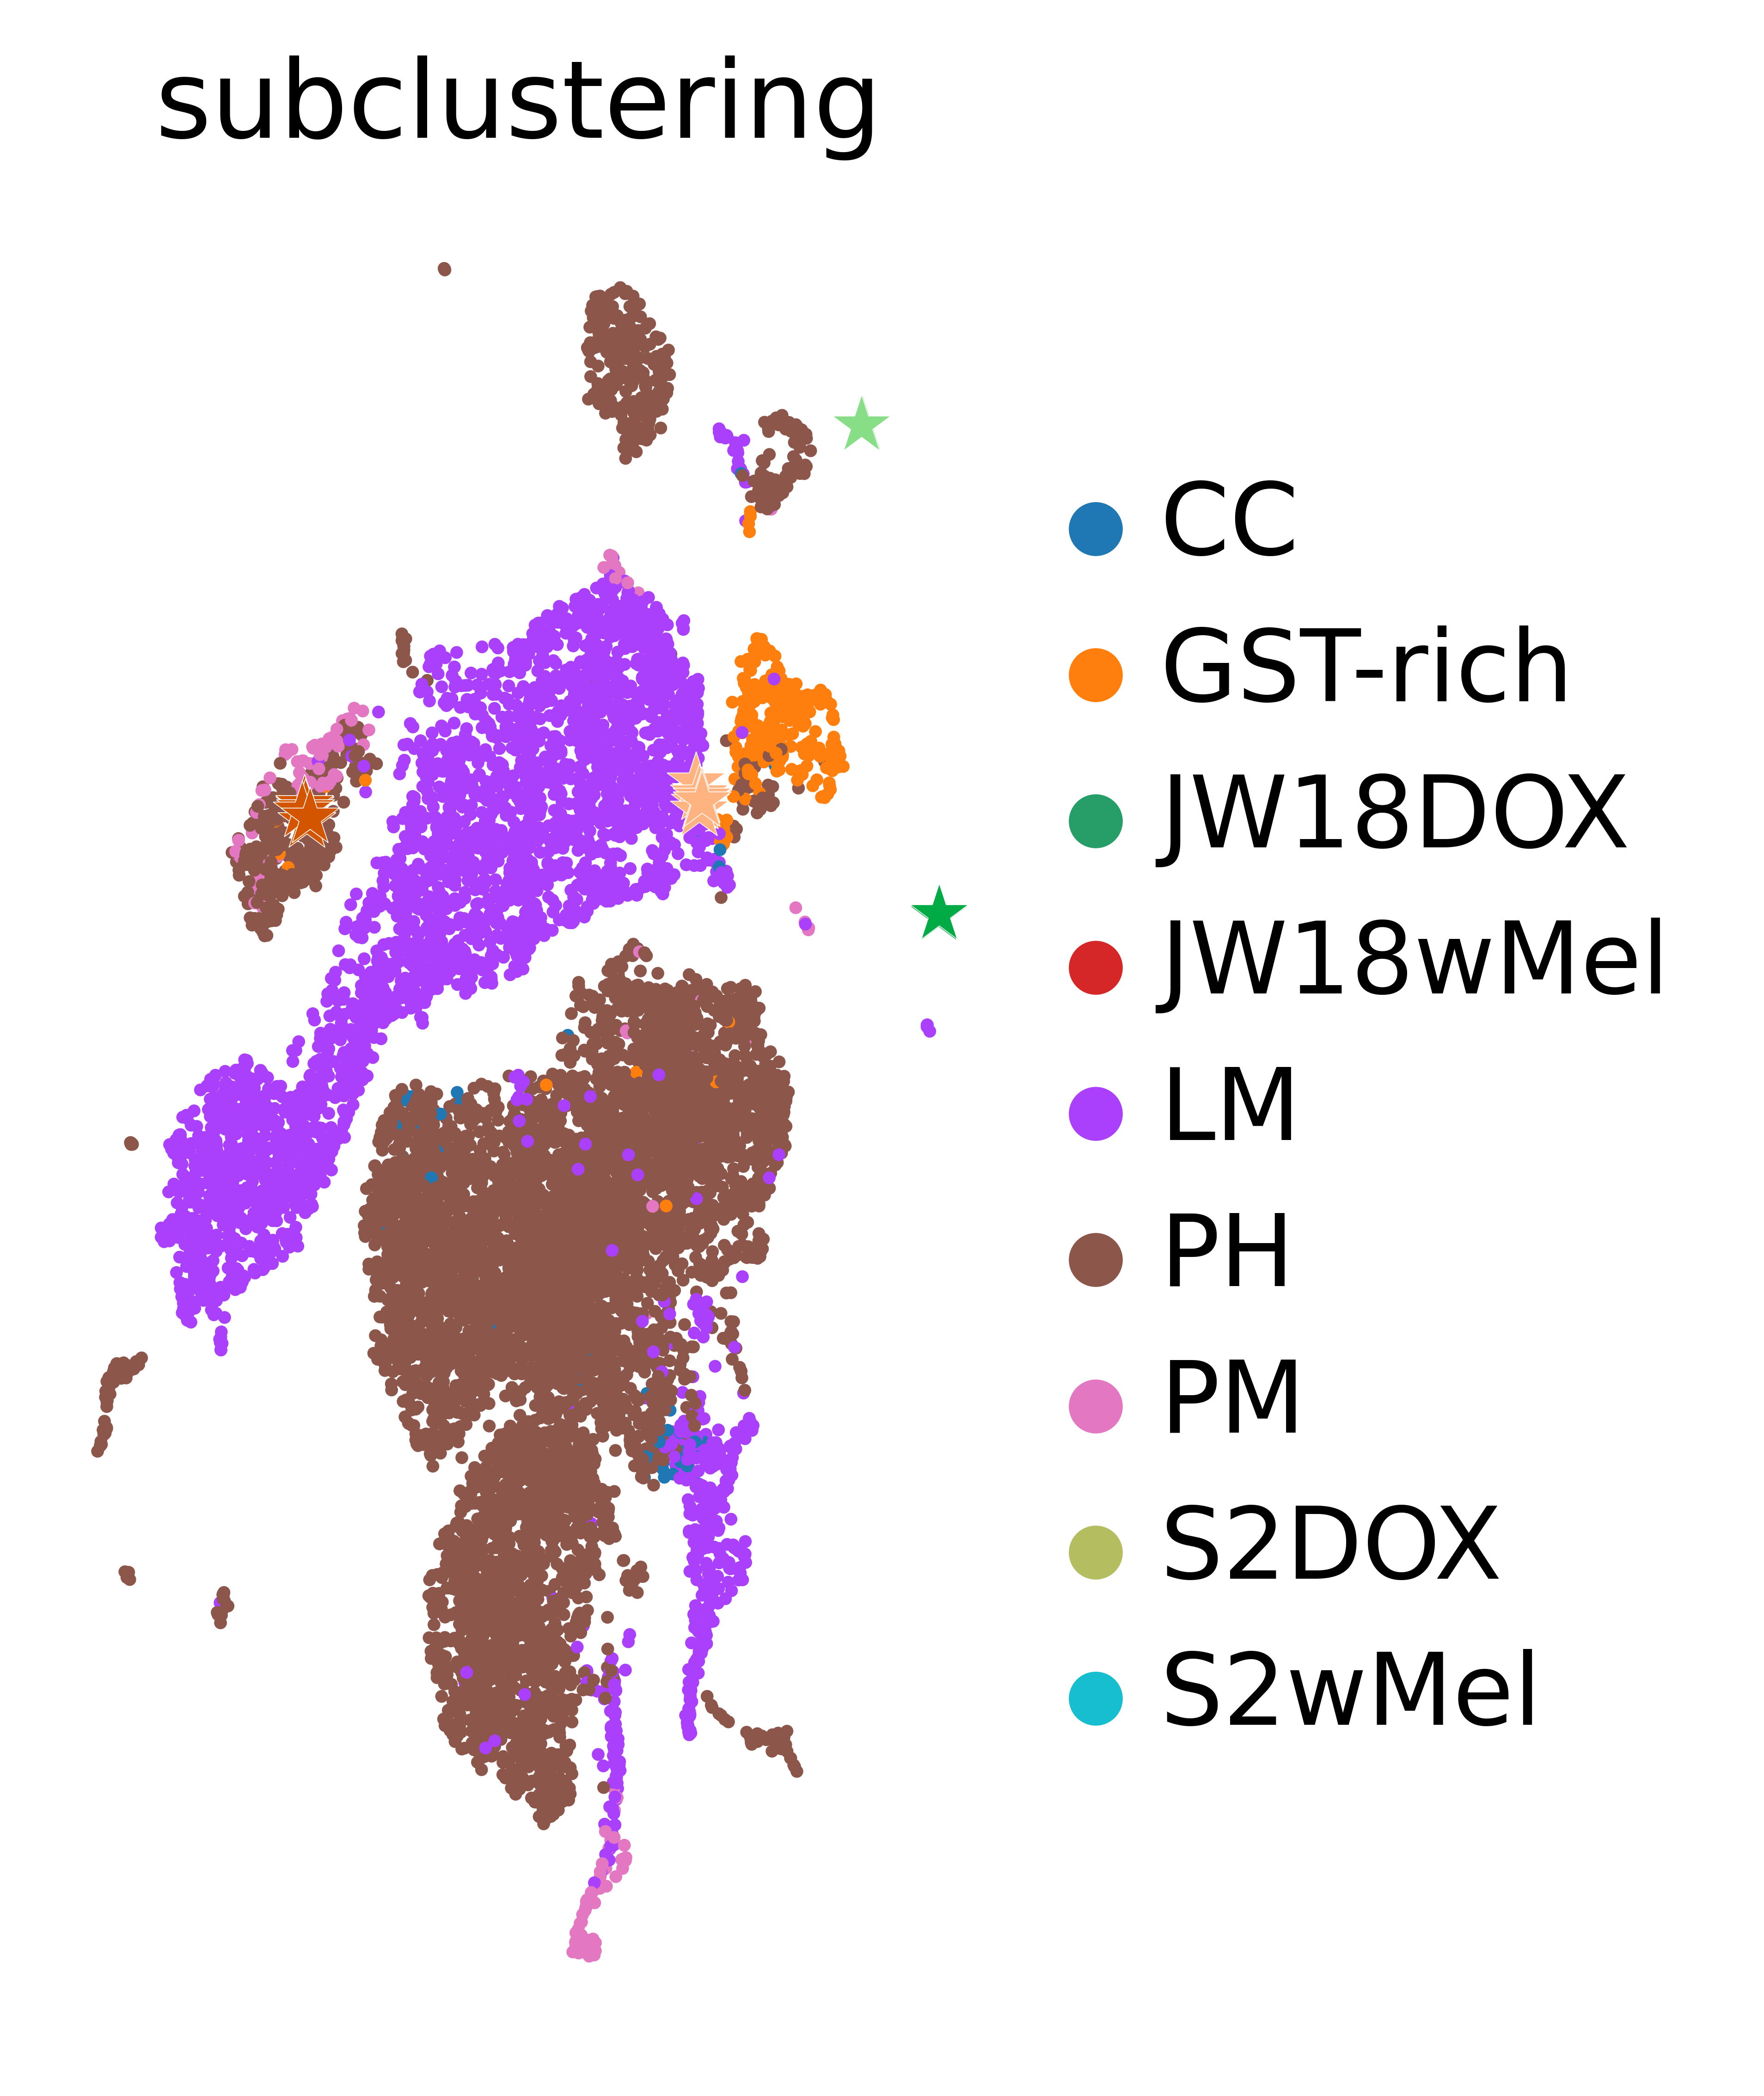

In [ ]:
#Annotate UMAP with larger markers
# Plot the UMAP
sc.pl.umap(combined_adata, color=[annotation_key], show=False)

# Get the UMAP coordinates
umap_coords = combined_adata.obsm['X_umap']

# Get your sample labels from the data
labels = combined_adata.obs['Sample']

# Iterate over each point and add a label if it's not NA
for idx, label in enumerate(labels):
    if pd.notna(label):  # Check if the label is not NA

        plt.plot(umap_coords[idx, 0], umap_coords[idx, 1], 
                color=color_dict[label[:-8]], 
                marker='*',            # '*' for star marker
                markersize=8,          # Increase size for better visibility
                markeredgecolor='white', # White outline
                markeredgewidth=0.1,   # Width of the outline
                alpha=1)    # Remove background grid and ticks for a cleaner look
plt.grid(False)

# Adjust layout to fit the legend outside
plt.tight_layout(rect=[0, 0, 0.85, 1])  # Leaves space for legend on the right
plt.savefig('combined_dataset_samples_and_tissue.pdf', dpi=600, bbox_inches="tight")
plt.show() 

# Save the plot
plt.savefig('marker_gene_clustering.pdf', dpi=600)
plt.close()

